In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'augmented-forest-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1650618%2F2738848%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T131122Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5b235c5a304c88d634d932be86d93ba68d65d9f2484497f50aa4111781a3ff2cbb8e470f7846d7e368c018f8fe5761d0e8ea29e1c322c6b5f14b6e673ff8442596b34d5e682aaab0b24d1c7408271fd052601fd8f542355e733c2bdc353f65268e2c4fab95b75ea8862d5299b0485600cc2b11dc40ca97cd97c5c0e43c4b004fcb8313179d9cf7d1bd992b2a88223cd1e628ee33acdbfb8308d7de9a120eb0719da4969e175101b9f82fe33e6113c0f6ad40136c27b2d69bf79a7d0a32ec89a7445965041f6a754a4e29dc5203e6a015ed343d153487621184657e9c7b4d3e8b2da066fcd07dcc7e3c451a90aa436858939ab26d28a1822f8ab6733cf5b0f815'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 180628283 bytes downloaded
Downloaded and uncompressed: augmented-forest-segmentation
Data source import complete.


In [2]:
!pip install tensorflow keras

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16

In [4]:
base_directory = '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

In [5]:
data.head()

image                mask
0   10452_sat_08.jpg   10452_mask_08.jpg
1   10452_sat_18.jpg   10452_mask_18.jpg
2  111335_sat_00.jpg  111335_mask_00.jpg
3  111335_sat_01.jpg  111335_mask_01.jpg
4  111335_sat_02.jpg  111335_mask_02.jpg

In [6]:
img_dim = 256

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_image_generator = image_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='training')

train_mask_generator = mask_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='validation')

val_mask_generator = mask_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 4342 images belonging to 1 classes.
Found 4342 images belonging to 1 classes.
Found 766 images belonging to 1 classes.
Found 766 images belonging to 1 classes.


In [7]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

# Visualization
- Image and its Corresponding Mask Image
- The white pixel areas are the regions of interest or the areas that we are interested to segment, i.e. in our case forests in an image
- The black pixels are the other regions that we are not interested in

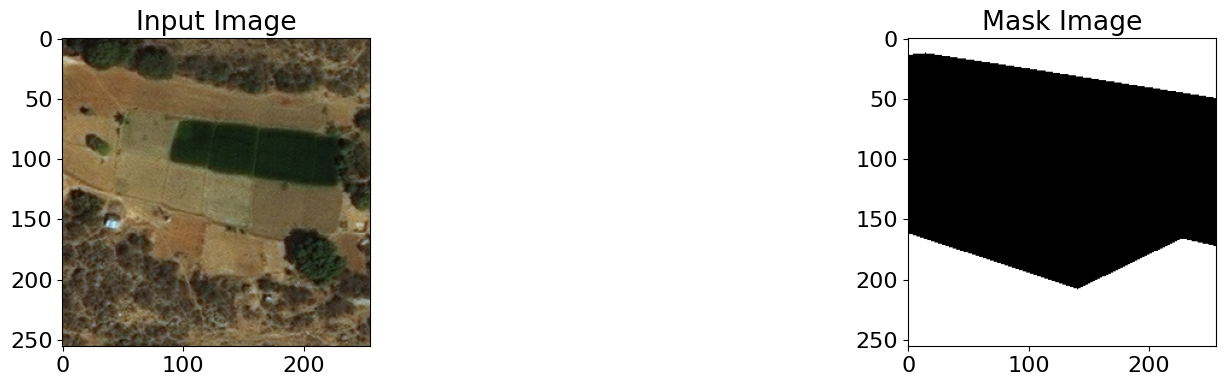

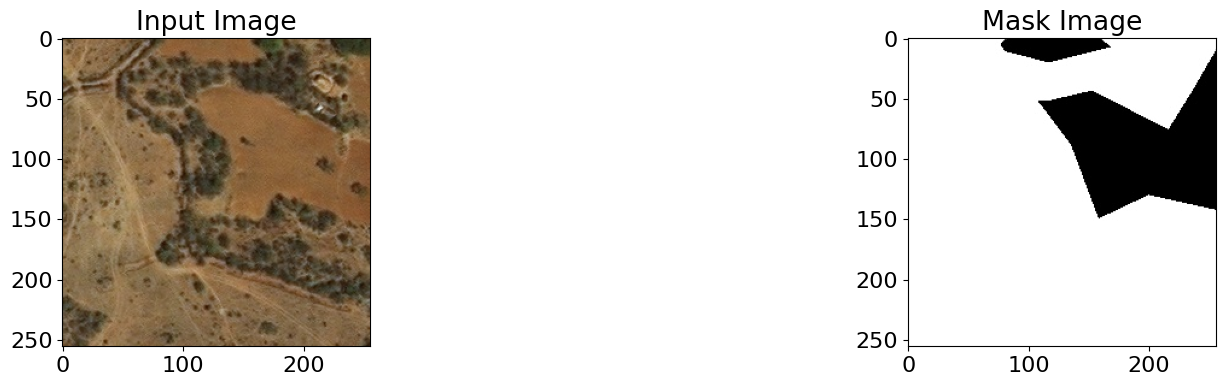

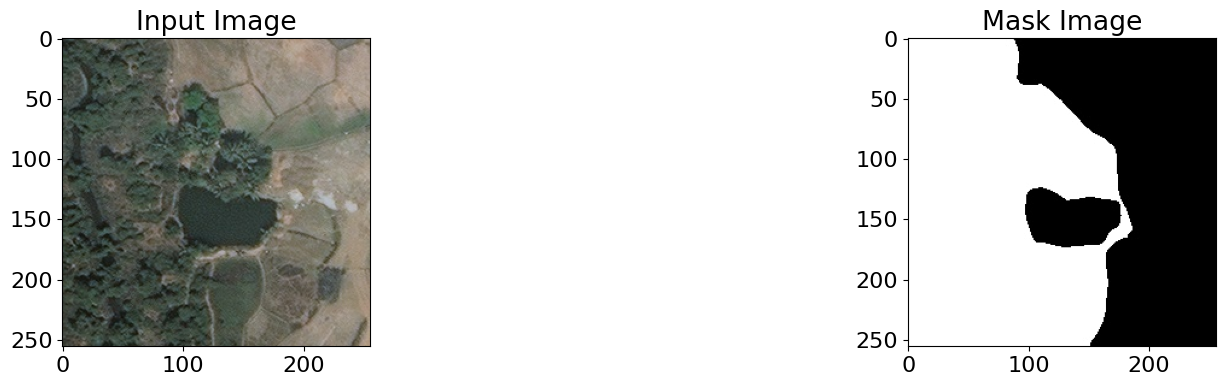

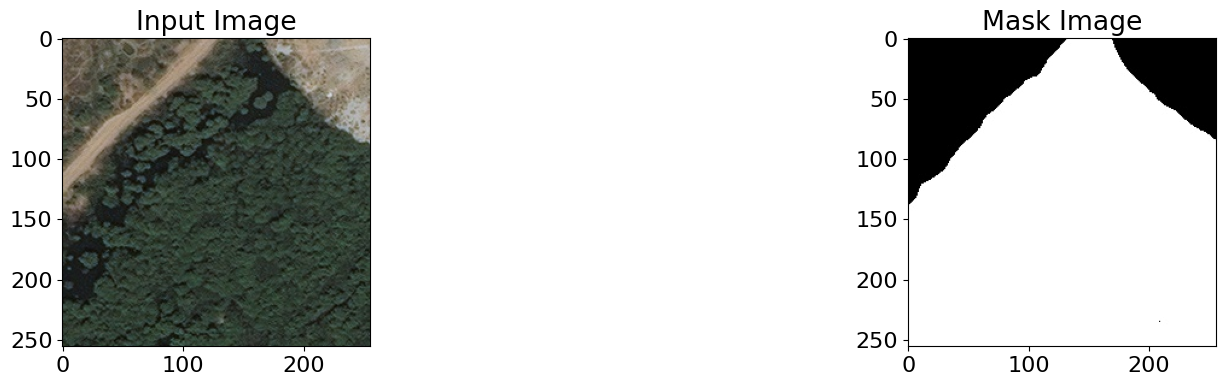

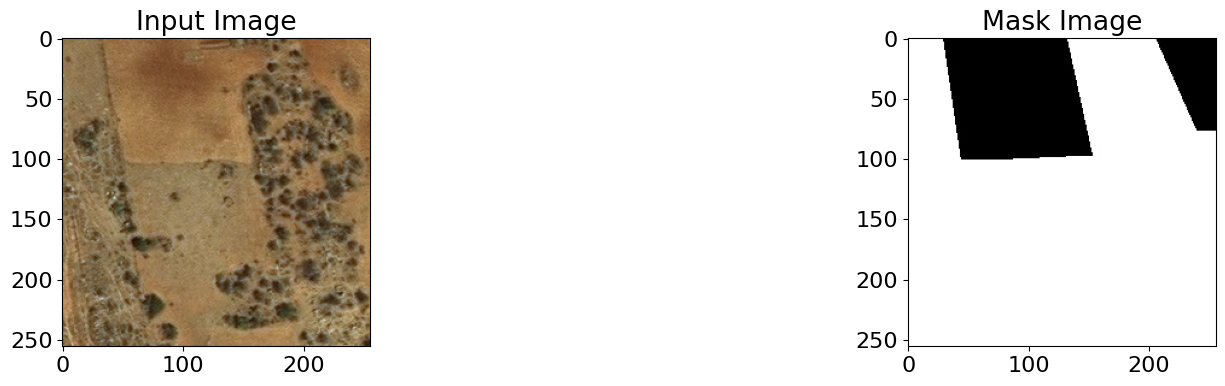

In [8]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

In [9]:
from tensorflow.keras import backend as K


# U-NET architechture

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder (Downsampling path)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder (Upsampling path)
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs, conv10)
    return model

# Instantiate the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [11]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [12]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

# Model Training
- Compile the model and set the remaining hyperparameters
- Add the required callbacks
- Feel free to monitor the iou_metric for early stopping, as for this kernel I have set the binary_crossentropy (default val loss) as the monitoring criteria
- We can also add iou_loss for the optimization or take a weighted average of both binary crossentropy and the iou to optimize the parameters of our model

In [13]:
Conv2D(1, (1, 1), activation='sigmoid')



# Partial cross entropy

In [14]:
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1 - epsilon)
        y_true = K.cast(y_true, K.floatx())

        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        return K.mean(fl)
    return focal_loss_fixed

def partial_cross_entropy(y_true, y_pred):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1 - epsilon)
    loss = -y_true * K.log(y_pred)  # Simplified to avoid direct multiplication by y_true
    return K.sum(loss) / K.sum(y_true)  # Normalizing by the number of positive cases

def combined_loss(y_true, y_pred, weights=[0.5, 0.5]):
    fl = focal_loss()(y_true, y_pred)
    pce = partial_cross_entropy(y_true, y_pred)
    return weights[0] * fl + weights[1] * pce

input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape)

# Adjust learning rate and add a more aggressive learning rate scheduler
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)



In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
    loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, weights=[0.3, 0.7]),  # Adjust weights here
    metrics=[iou_coef, 'accuracy'])

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d_21[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0][0

In [22]:

model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch=training_samples_size//32,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//32,
                    epochs=25,
                    callbacks=[ checkpoint])


Epoch 1/25
135/135 [==============================] - ETA: 0s - loss: 0.1367 - iou_coef: 0.6114 - accuracy: 0.7155
Epoch 00001: val_loss improved from inf to 0.18335, saving model to unet.h5
135/135 [==============================] - 98s 727ms/step - loss: 0.1367 - iou_coef: 0.6114 - accuracy: 0.7155 - val_loss: 0.1833 - val_iou_coef: 0.5811 - val_accuracy: 0.7652
Epoch 2/25
135/135 [==============================] - ETA: 0s - loss: 0.1356 - iou_coef: 0.6131 - accuracy: 0.7191
Epoch 00002: val_loss did not improve from 0.18335
135/135 [==============================] - 97s 717ms/step - loss: 0.1356 - iou_coef: 0.6131 - accuracy: 0.7191 - val_loss: 0.2427 - val_iou_coef: 0.5571 - val_accuracy: 0.7781
Epoch 3/25
135/135 [==============================] - ETA: 0s - loss: 0.1354 - iou_coef: 0.6127 - accuracy: 0.7224
Epoch 00003: val_loss did not improve from 0.18335
135/135 [==============================] - 96s 713ms/step - loss: 0.1354 - iou_coef: 0.6127 - accuracy: 0.7224 - val_loss: 0.

# Inferencing
- Learning Curves
- Ground Truth Masks vs Predicted Masks

In [17]:
import seaborn as sns
sns.set_style('dark')

## Learning Curve

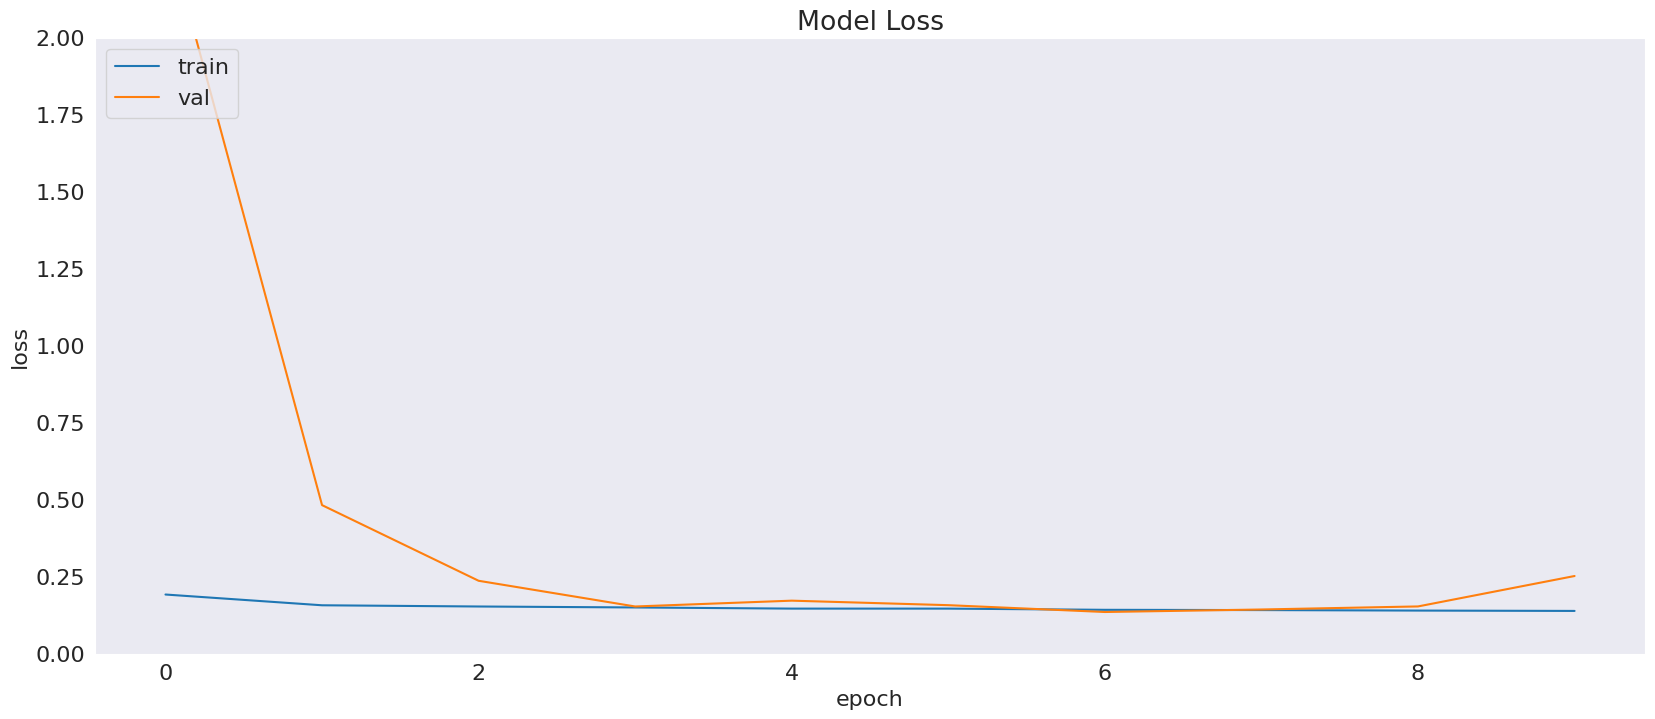

In [18]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
random_val_samples = val_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = model.predict(val_image_samples)

predicted_masks[predicted_masks >= 0.5] = 1
predicted_masks[predicted_masks < 0.5] = 0

1/1 [==============================] - 0s 415ms/step


## Ground Truth Masks vs Predicted Masks

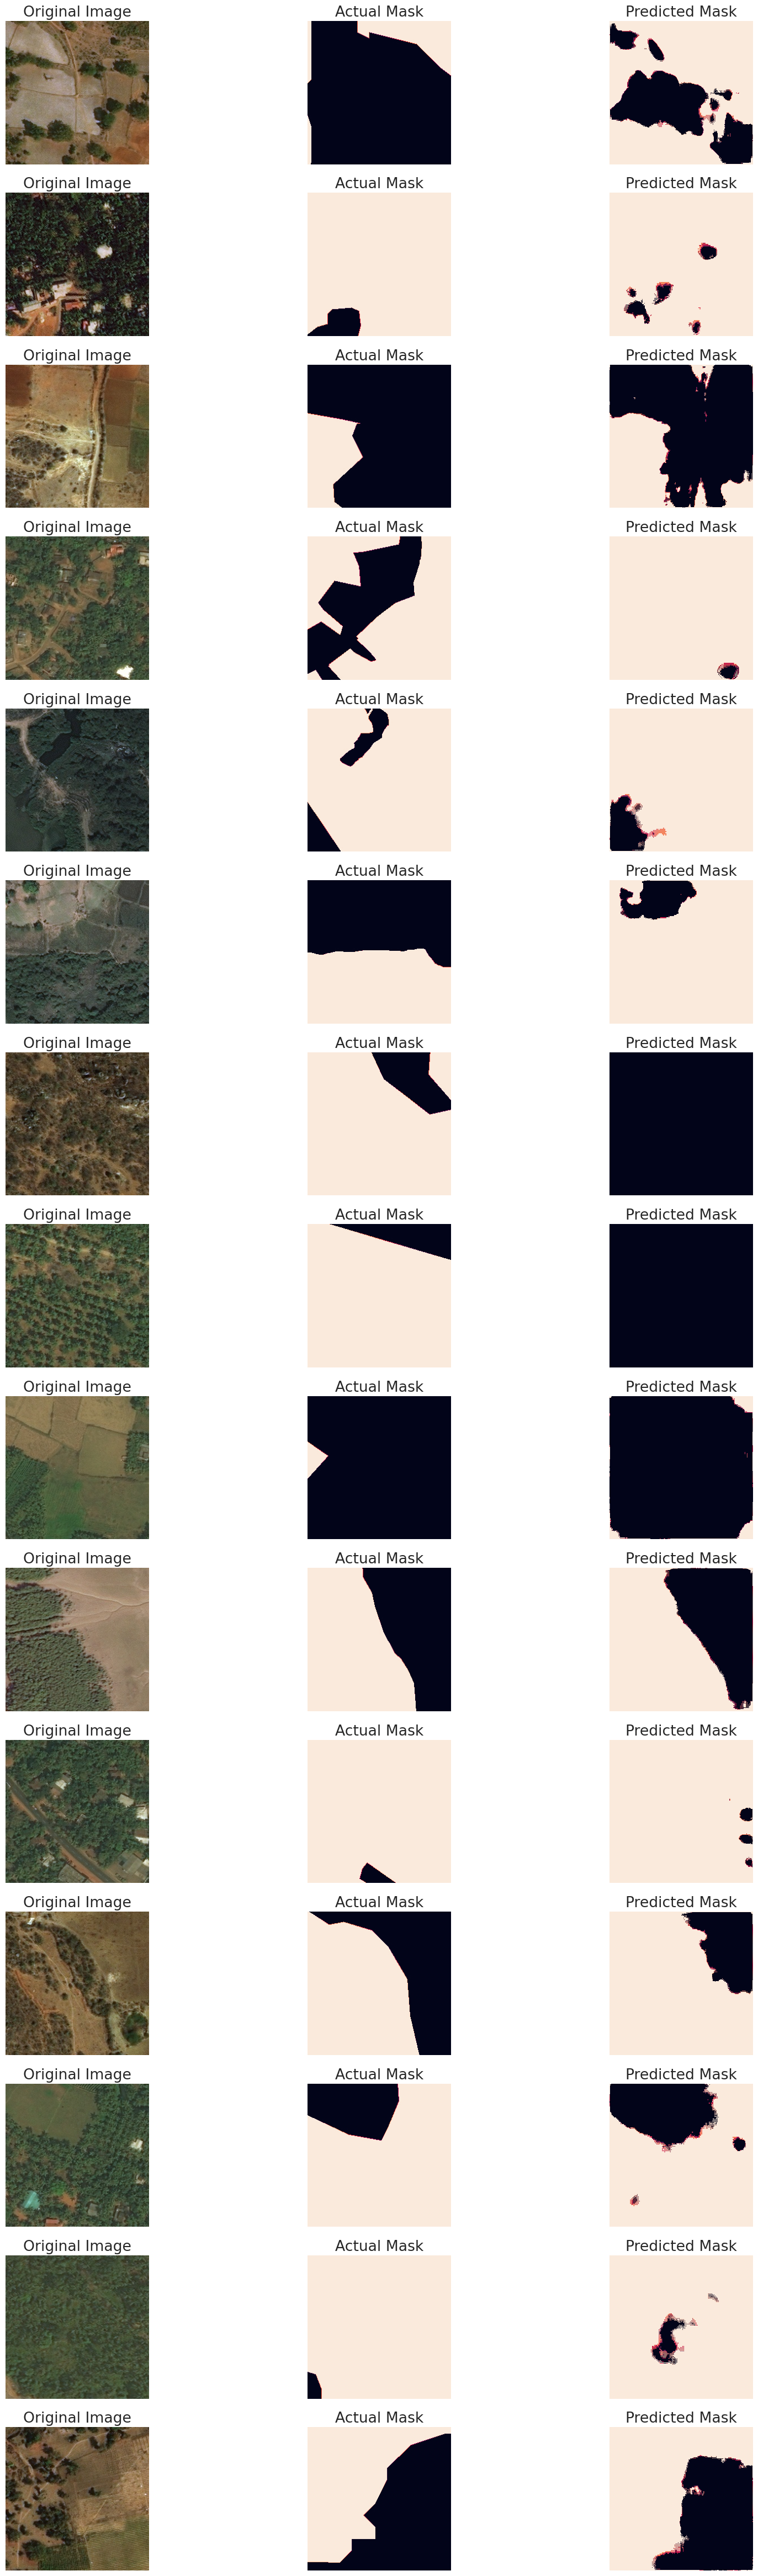

In [20]:
f, axarr = plt.subplots(15,3,figsize=(20, 60))

for i in range(0,15):

    axarr[i,0].imshow(val_image_samples[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,0].axis('off')
    axarr[i,1].imshow(val_mask_samples[i])
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,1].axis('off')
    axarr[i,2].imshow(predicted_masks[i])
    axarr[i,2].title.set_text('Predicted Mask')
    axarr[i,2].axis('off')

# Conclusion
- In some cases the segmented masks do not match with the ground truth mask. The reason behind this is that some of the images were not properly labelled during the data preparation.
- Therefore our model is able to identify certain features that help us segment the forest areas which are not labelled in ground truth images.
- However, the overall performance of our model can be improved by using different metrics relevant to image segmentation